# Create S1 RTC for Tindex (Super sites)

## Create S1 RTC stacks for each vector grid cell that intersects the Norway/Alaska super sites

- S1 RTC are in UTM
- Tindex is equal area above proj
- Datasets are transformed to 4326 for cross-referencing (as with HLS code)

In [2]:
# import libraries
import os
import rasterio as rio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import box
import folium
from pyproj import Transformer
from rio_tiler.io import COGReader
from rasterio.windows import from_bounds
import numpy as np
import numpy.ma as ma
from rasterio import enums
from rasterio.io import MemoryFile
from rasterio.crs import CRS
from rasterio.vrt import WarpedVRT
from rasterio.warp import array_bounds, calculate_default_transform
from rio_cogeo.profiles import cog_profiles
from rio_cogeo.cogeo import cog_translate
import affine

#### Open the boreal tindex (modified to include a smaller number of tiles) and store some key properties

In [3]:
# open the borel tindex
tindex = '/projects/my-public-bucket/sentinel1_seasonal_comps/Tindex/boreal_tiles_v003_S1RTC.gpkg'
tind = gpd.read_file(tindex)

In [4]:
# get vh and vv file lists
# create one df of data based on season and pol and intersection with tindex id
# eg, all S1 data that are spring + vh + tile 5335
# out geom is same as tindex
# out geom bbox is tindex tile geom

# root path to data
root_dir = "/projects/shared-buckets/nathanmthomas/sentinel1_seasonal_comps/"

# set up lists for attributes
season = []
polarization = []
location = []
sat_path = []
sat_row = []
filenames = []
filepaths = []
geom = []
tile_nums=[]

# get the crs of the tindex to apply later
out_crs = tind.crs
# make a 4326 copy for intersection later
tind_4326 = tind.to_crs("EPSG:4326")

# walk through dirs and get relevant data
for root, dirs, files in os.walk(root_dir, topdown=False):
    for name in files:
        if name.endswith('_median.tif'):
            with rio.open(os.path.join(root, name)) as f:
                # get image bounds and transform to 4326
                xmin, ymin, xmax, ymax = f.bounds
                transformer = Transformer.from_crs(f.crs, "EPSG:4326")
                ul = transformer.transform(xmin,ymax)
                lr = transformer.transform(xmax,ymin)
                #shapely box: minx, miny, maxx, maxy of S1 bounds
                poly = box(ul[1],lr[0],lr[1],ul[0])
                
                for index, row in tind.iterrows():
                    # get geom in 4326 for intersection
                    geom_box_4326 = tind_4326.iloc[index].geometry
                    # get geom in original crs
                    geom_box_orig = tind.iloc[index].geometry
                    # get tile number
                    tile_id = tind.tile_num.iloc[index]
                    # check intersection between S1 poly (4326) and tindex geom (4326)
                    if poly.intersects(geom_box_4326)==True:
                        # append attributes for row where intersection is true
                        tile_nums.append(tile_id)
                        filepaths.append(os.path.join(root, name))
                        filenames.append(name)
                        polarization.append(name.split('_')[6])
                        season.append(name.split('_')[5])
                        location.append(name.split('_')[0])
                        sat_path.append(name.split('_')[3])
                        sat_row.append(name.split('_')[4])
                        geom.append(geom_box_orig)

# write to one dataframe            
gdf = gpd.GeoDataFrame({'tile_num':tile_nums, 'filename':filenames, 'filepath':filepaths, 'season':season, 'pol':polarization, 'sat_row':sat_row, 'sat_path':sat_path, 'location':location, 'tile_num':tile_nums, 'geometry':geom}, crs=out_crs) 

gdf.head()

,tile_num,filename,filepath,season,pol,sat_row,sat_path,location,geometry
0,3179,Alaska_fid_1_p94_f210_Fall_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Fall,vh,f210,p94,Alaska,"POLYGON ((1448522.000 3393304.000, 1538522.000..."
1,3180,Alaska_fid_1_p94_f210_Fall_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Fall,vh,f210,p94,Alaska,"POLYGON ((1538522.000 3393304.000, 1628522.000..."
2,3270,Alaska_fid_1_p94_f210_Fall_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Fall,vh,f210,p94,Alaska,"POLYGON ((1268522.000 3303304.000, 1358522.000..."
3,3271,Alaska_fid_1_p94_f210_Fall_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Fall,vh,f210,p94,Alaska,"POLYGON ((1358522.000 3303304.000, 1448522.000..."
4,3272,Alaska_fid_1_p94_f210_Fall_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Fall,vh,f210,p94,Alaska,"POLYGON ((1448522.000 3303304.000, 1538522.000..."


#### read in data per tile, reduce and write

In [8]:
# filter DF for a specific subset of data
# This is a tile that intersects 3 S1 scenes with vv pol and spring season
sub_df = gdf.query('tile_num==3553 and season=="Spring"')
sub_df.head()

,tile_num,filename,filepath,season,pol,sat_row,sat_path,location,geometry
119,3553,Alaska_fid_1_p94_f210_Spring_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Spring,vh,f210,p94,Alaska,"POLYGON ((1448522.000 3033304.000, 1538522.000..."
137,3553,Alaska_fid_1_p94_f210_Spring_vv_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Spring,vv,f210,p94,Alaska,"POLYGON ((1448522.000 3033304.000, 1538522.000..."
146,3553,Alaska_fid_2_p94_f205_Spring_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Spring,vh,f205,p94,Alaska,"POLYGON ((1448522.000 3033304.000, 1538522.000..."
162,3553,Alaska_fid_2_p94_f205_Spring_vv_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Spring,vv,f205,p94,Alaska,"POLYGON ((1448522.000 3033304.000, 1538522.000..."
179,3553,Alaska_fid_3_p131_f378_Spring_vh_median.tif,/projects/shared-buckets/nathanmthomas/sentine...,Spring,vh,f378,p131,Alaska,"POLYGON ((1448522.000 3033304.000, 1538522.000..."


In [51]:
def read_cog(lut, out_bbox, in_out_crs):
    filepaths = lut['filepath'].to_list()
    comp_list = []
    # set some paramaters
    resolution = 30
    width = 3000
    height = 3000
    for file in filepaths:
        # partial read
        with COGReader(file) as cog:
            # set img bounds
            in_bbox = out_bbox
            # set crs to be tindex
            bounds_crs = in_out_crs
            # set dst crs to be tindex
            dst_crs = in_out_crs
            # Do window read
            img = cog.part(in_bbox, bounds_crs=bounds_crs, max_size=None, dst_crs=dst_crs, height=height, width=width)
            # append data to list where there are some S1 values
            # skips empty tiles where there is no S1 (or just nans)
            if np.amax(img.data) == 0:
                pass
            else:
                # append the data to a list
                comp_list.append(np.where(img.data==0, np.nan, img.data)) 
    
    
    # merge lists to 1 array and reduce to mean
    if len(comp_list) > 0:
        comp_arrays = np.array(comp_list)
        mean_arr = np.nanmean(comp_arrays,axis=0)
        
    return(mean_arr)

def write_cog(arr, outname, in_out_crs, out_bbox):
    print(outname)
    # set up write kwargs
    src_profile = dict(
        driver="GTiff",
        height=arr.shape[1],
        width=arr.shape[2],
        count=arr.shape[0],
        dtype=arr.dtype,
        crs=in_out_crs,
        #set affine tform
        #(res, 0, minx, 0, -res, maxy)
        transform = affine.Affine(30, 0, out_bbox[0], 0, -30, out_bbox[3]),
        compress='lzw',
        nodata=0)
    
    # write to disk
    new_dataset = rio.open(name, 'w', **src_profile)

    new_dataset.write(arr)
    new_dataset.close()
    
    
# Create the final composite
def create_s1_rtc(lut):
    # get paths of sub_df
    vv_lut = lut[lut['pol']=='vv']
    vh_lut = lut[lut['pol']=='vh']
    
    # get season, tile num, out_bbox and crs
    season = lut['season'].iloc[0]
    tile_num = lut['tile_num'].iloc[0]
    out_bbox = lut['geometry'].iloc[0].bounds
    in_out_crs = lut.crs
    
    path = '/projects/shared-buckets/nathanmthomas/sentinel1_seasonal_comps/'
    name = os.path.join(path, 's1_rtc_' + str(tile_num) + '_vvvh_' + season + '.tif')
    vv_comp = read_cog(vv_lut, out_bbox, in_out_crs)
    vh_comp = read_cog(vh_lut, out_bbox, in_out_crs)
    
    stack = np.vstack([vv_comp, vh_comp])
    print(np.shape(stack))
    write_cog(stack, name, in_out_crs, out_bbox)
    
    
    


In [53]:
create_s1_rtc(sub_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


(2, 3000, 3000)
/projects/shared-buckets/nathanmthomas/sentinel1_seasonal_comps/s1_rtc_3553_vvvh_Spring.tif
found


## Example: running `build_stack`

In [14]:
tind.head()

,tile_num,tile_version,tile_group,map_version,tile_number,geometry
0,1,version 1,eurasia west,None,1,"POLYGON ((-2151478.000 9423304.000, -2061478.0..."
1,2,version 1,eurasia west,None,2,"POLYGON ((-2061478.000 9423304.000, -1971478.0..."
2,3,version 1,eurasia west,None,3,"POLYGON ((-1971478.000 9423304.000, -1881478.0..."
3,4,version 1,eurasia west,None,4,"POLYGON ((-2241478.000 9333304.000, -2151478.0..."
4,5,version 1,eurasia west,None,5,"POLYGON ((-2151478.000 9333304.000, -2061478.0..."


##### Example of the footprints of the 'covariate' tiles
This will be a footprints of the SAR raster files that we want to return as rasters packed into out tiles extents

In [15]:
def get_geom_from_datasetmask(rio_dataset, GET_ONLY_DATASETMASK=True):
    import rasterio
    if GET_ONLY_DATASETMASK:
        results = (
                    {'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(rio_dataset.dataset_mask(), transform=rio_dataset.transform))
                )
    else:
        ma = np.ma.fix_invalid(rio_dataset.read())
        results = (
                    {'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(rio_dataset.read_masks(), transform=rio_dataset.transform))
                    #{'properties': {'raster_value': v}, 'geometry': s} for i, (s, v) in enumerate(rasterio.features.shapes(ma, transform=rio_dataset.transform))
                )
        
    geom = list(results)

    #return(geom, rio_dataset.crs)
    return(geom)

def raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=True, R_READ_MODE='r+', MANY_CRS=False, DISSOLVE_FIELD='file'):
    import rasterio
    try:
        with rasterio.open(r_fn, mode=R_READ_MODE) as dataset:

            if DO_DATAMASK:
                # TODO: Fix this. This flag does nothing right now
                if GET_ONLY_DATASETMASK:
                    job_string = 'valid data mask (high memory)'
                else:
                    job_string = 'valid data mask + the nodata (most memory)'
                #geom, dataset.crs = get_geom_from_datasetmask(dataset)
                geom = get_geom_from_datasetmask(dataset, GET_ONLY_DATASETMASK=GET_ONLY_DATASETMASK)

            else:
                job_string = 'raster image bounds (low memory)'
                geom = get_geom_from_bounds(dataset)
            
            # Dissolve so you dont return 1 polygon for each unique raster value...
            footprints_gdf  = gpd.GeoDataFrame.from_features(geom, crs=dataset.crs)
            
            #print(footprints_gdf.crs.axis_info[0].unit_name)
            #print(dataset.crs)

            footprints_gdf['path'], footprints_gdf['file'] = os.path.split(r_fn)
            footprints_gdf['local_path'] = r_fn
            if DISSOLVE_FIELD in footprints_gdf.columns:
                footprints_gdf = footprints_gdf.dissolve(by=DISSOLVE_FIELD, as_index=False)
                footprints_gdf = footprints_gdf.drop(columns=['raster_value'])
            else:
                print(f"Can't dissolve by {DISSOLVE_FIELD}. Field not found.")

            if False:
                print(f'Getting {job_string} for: {os.path.basename(r_fn)} ...')

            if 'm' in footprints_gdf.crs.axis_info[0].unit_name:
                # Get area
                footprints_gdf["area_km2"] = footprints_gdf['geometry'].area/1e6
                footprints_gdf["area_ha"] = footprints_gdf['geometry'].area/1e4

            if MANY_CRS:
                #print('There are multiple CRSs in this set, so reprojecting everything to 4326...')
                footprints_gdf = footprints_gdf.to_crs(4326)

            return footprints_gdf
    except Exception as e: 
        print(e)
        print(r_fn)
    
def build_footprint_db(gdf_list, TO_GCS=True, WRITE_GPKG=True, OUT_F_NAME='footprints.gpkg', OUT_LYR_NAME='footprints', DROP_DUPLICATES=True):
    
    print("Building GDF from list...")
    footprints_gdf = gpd.GeoDataFrame( pd.concat( gdf_list, ignore_index=True) )
    
    if DROP_DUPLICATES:
        footprints_gdf = footprints_gdf.drop_duplicates()
    
    if TO_GCS:
        print("Converting to GCS...")
        footprints_gdf = footprints_gdf.to_crs({'init': 'epsg:4326'})
        
    if WRITE_GPKG:
        footprints_gdf.to_file(OUT_F_NAME, driver="GPKG", layer=OUT_LYR_NAME)
        print(f"Wrote out spatial footprints to {OUT_F_NAME}")
        
    return footprints_gdf

def local_to_s3(url, user = 'nathanmthomas', type='public'):
    ''' A Function to convert local paths to s3 urls'''
    if type == 'public':
        replacement_str = f's3://maap-ops-workspace/shared/{user}'
    else:
        replacement_str = f's3://maap-ops-workspace/{user}'
    return url.replace(f'/projects/my-{type}-bucket', replacement_str)

### Building covariate (SAR) data mask footprints

In [16]:
import glob, os
import pandas as pd

fn_sar_list_ak = glob.glob('/projects/my-public-bucket/sentinel1_seasonal_comps/Alaska*/*tif')
fn_sar_list_norway = glob.glob('/projects/my-public-bucket/sentinel1_seasonal_comps/Norway*/*tif')
fn_sar_list = fn_sar_list_ak + fn_sar_list_norway
fn_sar_list[0:2]

['/projects/my-public-bucket/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_1_p94_f210_Fall_vh_median.tif',
 '/projects/my-public-bucket/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_1_p94_f210_Fall_vv_median.tif']

Building GDF from list...


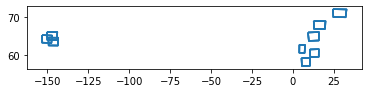

In [17]:
if False:
    out_foot_fn = '/projects/my-public-bucket/sentinel1_seasonal_comps/footprints_sentinel1_seasonal.gpkg'
    f_gdf_lst = [raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True, DISSOLVE_FIELD='file') for r_fn in fn_sar_list]
    footprint_gdf = build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME=out_foot_fn, OUT_LYR_NAME='s1')
    footprint_gdf.boundary.plot()
    
    footprint_gdf['s3_path'] = [local_to_s3(f, user='nathanmthomas') for f in footprint_gdf['local_path'].tolist()]
    footprint_gdf.to_file(out_foot_fn, driver='GPKG')
    footprint_gdf.head()

In [18]:
footprint_gdf['s3_path'] = [local_to_s3(f, user='nathanmthomas') for f in footprint_gdf['local_path'].tolist()]
footprint_gdf.to_file(out_foot_fn, driver='GPKG')
footprint_gdf.head()

,file,geometry,path,local_path,area_km2,area_ha,s3_path
0,Alaska_fid_1_p94_f210_Fall_vh_median.tif,"POLYGON ((-150.26604 65.97773, -150.02450 63.9...",/projects/my-public-bucket/sentinel1_seasonal_...,/projects/my-public-bucket/sentinel1_seasonal_...,66113.2800,6611328.00,s3://maap-ops-workspace/shared/nathanmthomas/s...
1,Alaska_fid_1_p94_f210_Fall_vv_median.tif,"POLYGON ((-150.26604 65.97773, -150.02450 63.9...",/projects/my-public-bucket/sentinel1_seasonal_...,/projects/my-public-bucket/sentinel1_seasonal_...,66113.2800,6611328.00,s3://maap-ops-workspace/shared/nathanmthomas/s...
2,Alaska_fid_2_p94_f205_Fall_vh_median.tif,"POLYGON ((-149.39174 64.53082, -149.22446 62.4...",/projects/my-public-bucket/sentinel1_seasonal_...,/projects/my-public-bucket/sentinel1_seasonal_...,67143.1995,6714319.95,s3://maap-ops-workspace/shared/nathanmthomas/s...
3,Alaska_fid_2_p94_f205_Fall_vv_median.tif,"POLYGON ((-149.39174 64.53082, -149.22446 62.4...",/projects/my-public-bucket/sentinel1_seasonal_...,/projects/my-public-bucket/sentinel1_seasonal_...,67143.1995,6714319.95,s3://maap-ops-workspace/shared/nathanmthomas/s...
4,Alaska_fid_3_p131_f378_Fall_vh_median.tif,"POLYGON ((-153.17586 65.17088, -153.16378 63.1...",/projects/my-public-bucket/sentinel1_seasonal_...,/projects/my-public-bucket/sentinel1_seasonal_...,62302.0680,6230206.80,s3://maap-ops-workspace/shared/nathanmthomas/s...


In [40]:
# covar_foot_index = gpd.read_file('/projects/my-public-bucket/DPS_tile_lists/HT/winter2023/map_boreal_2022_rh_ground_v1/HT_tindex_master.json')
# covar_foot_index.head()

In [19]:
TILE_NUM = 3553

In [20]:
BUILD_STACK_DICT_LIST = [
        {
            'INDEX_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',#'/projects/my-public-bucket/sentinel1_seasonal_comps/Tindex/boreal_tiles_v003_S1RTC.gpkg',
            'ID_COL_NAME':'tile_num',
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':'boreal_tiles_v003',
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 's1',
            'COVAR_TILE_FN': out_foot_fn,
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'/projects/my-public-bucket/sentinel1_seasonal_comps/out_build_stack',
            'CREDENTIALS_FN': None
        }
    ]


In [21]:
BUILD_STACK_DICT = BUILD_STACK_DICT_LIST[0]
BUILD_STACK_DICT

{'INDEX_FN': '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
 'ID_COL_NAME': 'tile_num',
 'TILE_NUM': 3553,
 'INDEX_LYR': 'boreal_tiles_v003',
 'RASTER_NAME': 's1',
 'COVAR_TILE_FN': '/projects/my-public-bucket/sentinel1_seasonal_comps/footprints_sentinel1_seasonal.gpkg',
 'IN_COVAR_S3_COL': 's3_path',
 'NODATA_VAL': -9999,
 'OUTPUT_CLIP_COG_FN': '/projects/my-public-bucket/sentinel1_seasonal_comps/out_build_stack',
 'CREDENTIALS_FN': None}

In [22]:
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
from build_stack import *
def run_build_stack():
        build_stack_(
            stack_tile_fn = BUILD_STACK_DICT['INDEX_FN'], 
            in_tile_id_col = BUILD_STACK_DICT['ID_COL_NAME'], 
            stack_tile_id = BUILD_STACK_DICT['TILE_NUM'],
            tile_buffer_m = 0, 
            stack_tile_layer = BUILD_STACK_DICT['INDEX_LYR'],
            covar_tile_fn = BUILD_STACK_DICT['COVAR_TILE_FN'],
            in_covar_s3_col = BUILD_STACK_DICT['IN_COVAR_S3_COL'], 
            res = 30, 
            input_nodata_value = BUILD_STACK_DICT['NODATA_VAL'],
            tmp_out_path = '/projects/tmp', 
            covar_src_name = BUILD_STACK_DICT['RASTER_NAME'],
            clip = True, 
            topo_off = True, 
            output_dir = BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'],
            height = None,
            width = None
           )


In [23]:
run_build_stack()

The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 3553:
 s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_1_p94_f210_Fall_vh_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_1_p94_f210_Fall_vv_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_2_p94_f205_Fall_vh_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_2_p94_f205_Fall_vv_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_3_p131_f378_Fall_vh_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Fall/Alaska_fid_3_p131_f378_Fall_vv_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentinel1_seasonal_comps/Alaska_Spring/Alaska_fid_1_p94_f210_Spring_vh_median.tif
s3://maap-ops-workspace/shared/nathanmthomas/sentin

/projects/.local/lib/python3.7/site-packages/rio_tiler/io/cogeo.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  NoOverviewWarning,
/projects/Developer/icesat2_boreal/lib/build_stack.py:162: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  input_nodata_value=input_nodata_value
Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/a3471564-a2f2-48a3-8713-6ee1bcae49dd/a3471564-a2f2-48a3-8713-6ee1bcae49dd.tif)' mode='r'>


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/sentinel1_seasonal_comps/out_build_stack/s1_3553_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 3000, 3000)
Output resolution:		 (30, 30)
Writing img to memory...
{'driver': 'VRT', 'dtype': 'float32', 'nodata': -9999, 'width': 3000, 'height': 3000, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 1448521.9999999953,
       0.0, -30.0, 3033304.0000000093), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/sentinel1_seasonal_comps/out_build_stack/s1_3553_cog.tif


Image written to disk:		 /projects/my-public-bucket/sentinel1_seasonal_comps/out_build_stack/s1_3553_cog.tif
